In [71]:
import numpy as np
from pathlib import Path
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from models import muq, RoBERTa
import librosa
import soundfile as sf
import torch
from main import *

SAMPLING_RATE = 44100


In [39]:
parameters = {
        "sound_corpus_path": "./corpora/sound/toy",
        "text_corpus_path": "./corpora/text/repeat.txt",
        "sound_encoder": "MuQ",
        "text_encoder": "RoBERTa",
        "output_path": "./output",
        "grain_size": 1000,  # in ms
        "distance": "euclidean",
        "trim_silence": True,
}

# a function that determines how to separate sounds
grain_size = int(parameters['grain_size'] / 1000.0 * SAMPLING_RATE)  # convert to samples
slice_fn = lambda y: equal_slices(y, grain_size)

sound_corpus_path = Path(parameters["sound_corpus_path"])
text_corpus_path = Path(parameters["text_corpus_path"])

if parameters["sound_encoder"] == "MuQ":
    sound_encoder = muq
if parameters["text_encoder"] == "RoBERTa":
    text_encoder = RoBERTa

print("Loading sound and text data...")
sound_corpus = load_soundfiles(sound_corpus_path)
sound_corpus = preprocess_sounds(sound_corpus, slice_fn, parameters["trim_silence"])

text_corpus = load_text_corpus(text_corpus_path)

print("Embedding sounds...")
sound_embeddings = embed_sounds(sound_corpus, sound_encoder)

print("Embedding text...")

text_embeddings = embed_text(" ".join(text_corpus), text_encoder)

Loading sound and text data...
Embedding sounds...


C:\Users\dzluk\.conda\envs\QE\lib\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


MuQ: feature shape:  torch.Size([1, 11, 1024])
MuQ: feature shape:  torch.Size([1, 8, 1024])
MuQ: feature shape:  torch.Size([1, 25, 1024])
MuQ: feature shape:  torch.Size([1, 25, 1024])
MuQ: feature shape:  torch.Size([1, 25, 1024])
MuQ: feature shape:  torch.Size([1, 25, 1024])
MuQ: feature shape:  torch.Size([1, 25, 1024])
MuQ: feature shape:  torch.Size([1, 25, 1024])
MuQ: feature shape:  torch.Size([1, 25, 1024])
MuQ: feature shape:  torch.Size([1, 25, 1024])
MuQ: feature shape:  torch.Size([1, 25, 1024])
MuQ: feature shape:  torch.Size([1, 25, 1024])
MuQ: feature shape:  torch.Size([1, 25, 1024])
MuQ: feature shape:  torch.Size([1, 25, 1024])
MuQ: feature shape:  torch.Size([1, 25, 1024])
MuQ: feature shape:  torch.Size([1, 25, 1024])
MuQ: feature shape:  torch.Size([1, 25, 1024])
MuQ: feature shape:  torch.Size([1, 25, 1024])
MuQ: feature shape:  torch.Size([1, 25, 1024])
MuQ: feature shape:  torch.Size([1, 25, 1024])
MuQ: feature shape:  torch.Size([1, 25, 1024])
MuQ: feature s

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RoBERTa: number of tokens:  10


In [72]:
normalization = StandardScaler()
dim = 2  # the number of dimensions to reduce to
mapping = 'cluster'

print("Transforming embeddings...")
# what transformations will we apply to the feature space?
transform_pipeline = create_pipeline(normalization, dim)
for transform in transform_pipeline:
    sound_embeddings = transform(sound_embeddings)
    text_embeddings = transform(text_embeddings)

print(f"Mapping text to sound with method {mapping}...")
# mapping options: identity, cluster_map
if mapping == "identity":
    mapping_fn = identity
elif mapping == "cluster":
    mapping_fn = cluster_map
else:
    raise Exception("Invalid mapping provided")

neighbor_indices = mapping_fn(sound_embeddings, text_embeddings, parameters['distance'])

print("Fetching sounds...")
output_sounds = [sound_corpus[i] for i in neighbor_indices]

print("Saving output...")
save_output(output_sounds, Path(parameters["output_path"]))

print("Done.")

Transforming embeddings...
Mapping text to sound with method cluster...


NameError: name 'cluster_map' is not defined

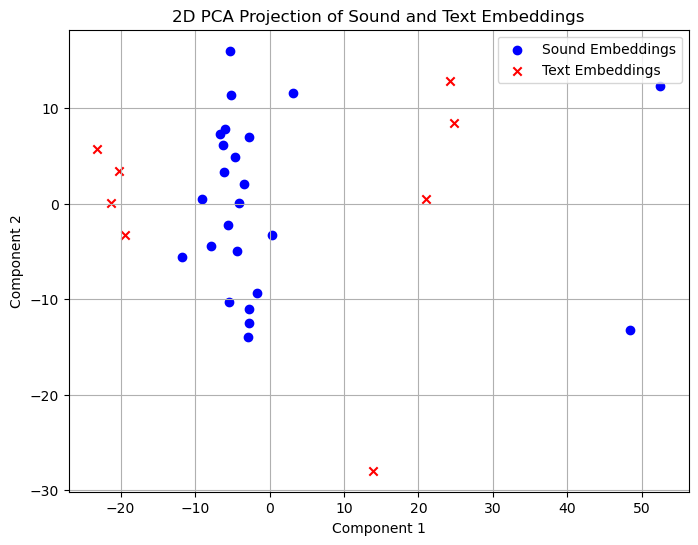

In [41]:
import matplotlib.pyplot as plt

def plot_2d_embeddings(sound_embeddings, text_embeddings):
    plt.figure(figsize=(8, 6))

    # Plot sound embeddings (in blue)
    plt.scatter(sound_embeddings[:, 0], sound_embeddings[:, 1], color='blue', marker='o', label='Sound Embeddings', alpha=1)

    # Plot text embeddings (in red)
    plt.scatter(text_embeddings[:, 0], text_embeddings[:, 1], color='red', marker='x', label='Text Embeddings', alpha=1)

    # Add labels and legend
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title('2D PCA Projection of Sound and Text Embeddings')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_2d_embeddings(sound_embeddings, text_embeddings)

C:\Users\dzluk\AppData\Local\Temp\ipykernel_6212\2590189125.py:12: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(highlighted_text[0], highlighted_text[1], color='red', marker='x', s=100, edgecolors='black', label='Input Text', zorder=5)


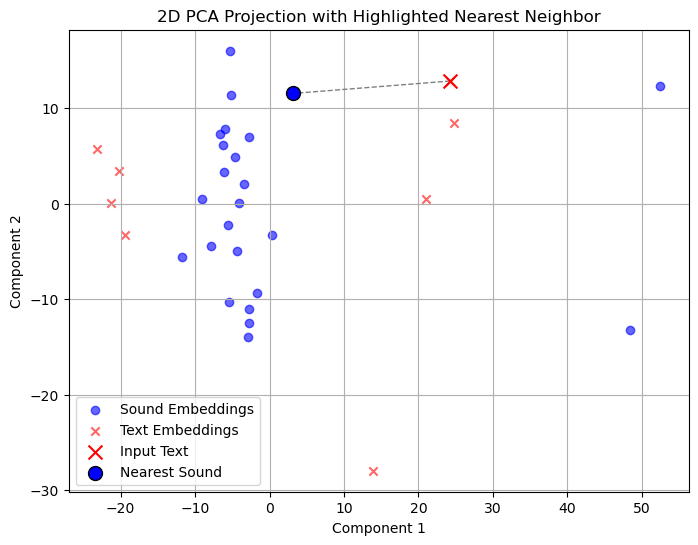

In [42]:
def plot_2d_embeddings_with_highlight(sound_embeddings, text_embeddings, highlighted_text_idx, nearest_sound_idx):
    plt.figure(figsize=(8, 6))

    # Plot all sound embeddings (in blue)
    plt.scatter(sound_embeddings[:, 0], sound_embeddings[:, 1], color='blue', label='Sound Embeddings', alpha=0.6)

    # Plot all text embeddings (in red)
    plt.scatter(text_embeddings[:, 0], text_embeddings[:, 1], color='red', marker='x', label='Text Embeddings', alpha=0.6)

    # Highlight the specific text embedding (in green)
    highlighted_text = text_embeddings[highlighted_text_idx]
    plt.scatter(highlighted_text[0], highlighted_text[1], color='red', marker='x', s=100, edgecolors='black', label='Input Text', zorder=5)

    # Highlight the nearest neighbor sound embedding (in purple)
    nearest_sound = sound_embeddings[nearest_sound_idx]
    plt.scatter(nearest_sound[0], nearest_sound[1], color='blue', s=100, edgecolors='black', label='Nearest Sound', zorder=5)

    # Draw an arrow or line between the points
    plt.plot([highlighted_text[0], nearest_sound[0]],
             [highlighted_text[1], nearest_sound[1]],
             color='gray', linestyle='--', linewidth=1)

    # Add labels and legend
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title('2D PCA Projection with Highlighted Nearest Neighbor')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_2d_embeddings_with_highlight(sound_embeddings, text_embeddings, 6, neighbor_indices[6])

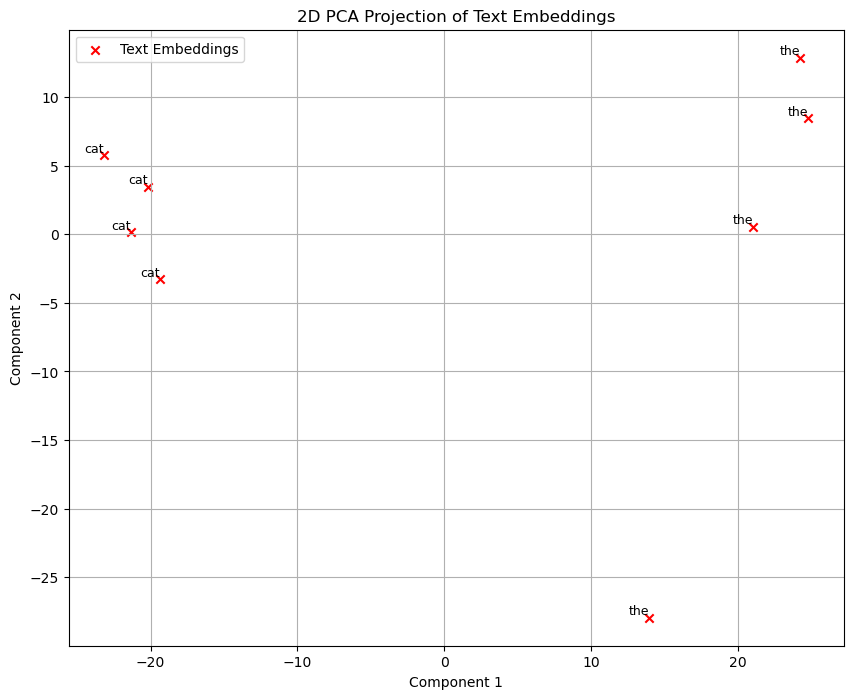

In [43]:
def plot_text_embeddings_with_labels(text_embeddings, text_corpus):
    assert text_embeddings.shape[0] == len(text_corpus)
    plt.figure(figsize=(10, 8))

    # Plot text embeddings with red 'x' markers
    plt.scatter(text_embeddings[:, 0], text_embeddings[:, 1], color='red', marker='x', label='Text Embeddings')

    # Add labels to each point
    for i, word in enumerate(text_corpus):
        plt.text(text_embeddings[i, 0], text_embeddings[i, 1], word, fontsize=9, ha='right', va='bottom')

    # Formatting
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title('2D PCA Projection of Text Embeddings')
    plt.legend()
    plt.grid(True)

    plt.show()

plot_text_embeddings_with_labels(text_embeddings, text_corpus)

Sound Cluster centers: [[-4.58427511e+00  4.06214729e-02]
 [ 5.04270262e+01 -4.46836202e-01]]
Sound Labels: [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Text Cluster centers: [[ 21.01464607  -1.52150112]
 [-21.01464607   1.52150112]]
Text Labels: [0 1 0 1 0 1 0 1]


C:\Users\dzluk\.conda\envs\QE\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\dzluk\.conda\envs\QE\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


<Figure size 1200x600 with 0 Axes>

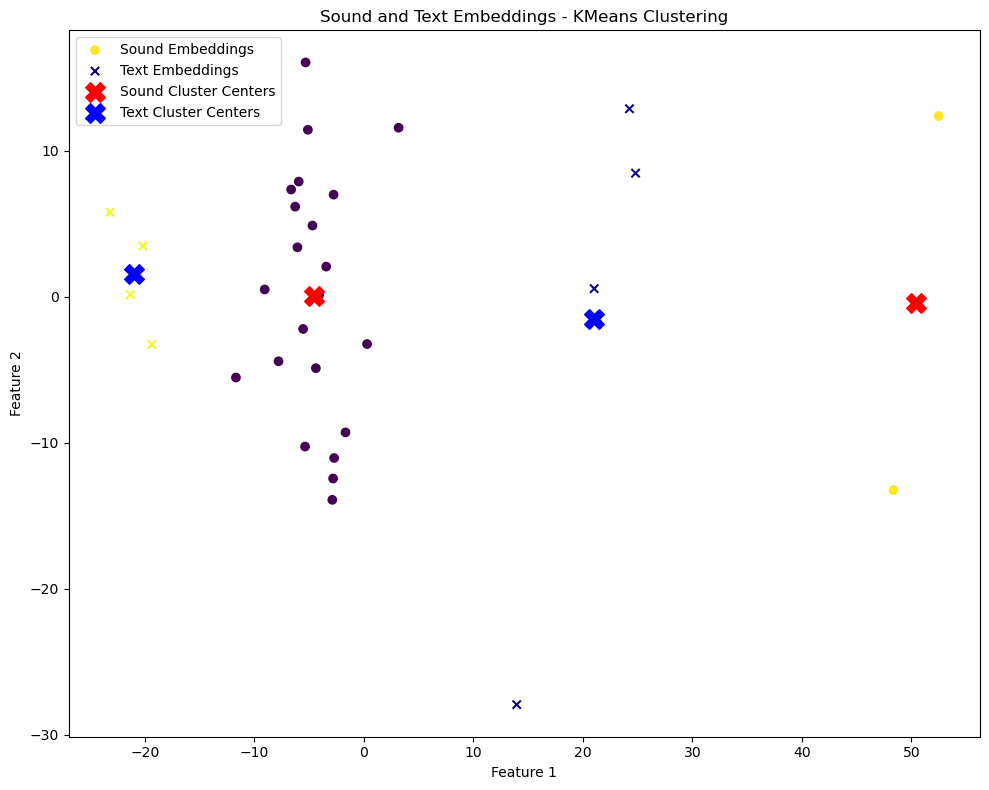

In [51]:
from sklearn.cluster import KMeans

k = 2
kmeans_sound = KMeans(n_clusters=k, n_init=10).fit(sound_embeddings)
kmeans_text = KMeans(n_clusters=k, n_init=10).fit(text_embeddings)

# Results
print("Sound Cluster centers:", kmeans_sound.cluster_centers_)
print("Sound Labels:", kmeans_sound.labels_)
print("Text Cluster centers:", kmeans_text.cluster_centers_)
print("Text Labels:", kmeans_text.labels_)

plt.figure(figsize=(12, 6))

# Visualizing Sound and Text Clusters on the Same Plot
plt.figure(figsize=(10, 8))

# Plot sound embeddings
plt.scatter(sound_embeddings[:, 0], sound_embeddings[:, 1], c=kmeans_sound.labels_, cmap='viridis', marker='o', label='Sound Embeddings')

# Plot text embeddings
plt.scatter(text_embeddings[:, 0], text_embeddings[:, 1], c=kmeans_text.labels_, cmap='plasma', marker='x', label='Text Embeddings')

# Plot cluster centers
plt.scatter(kmeans_sound.cluster_centers_[:, 0], kmeans_sound.cluster_centers_[:, 1], s=200, c='red', marker='X', label='Sound Cluster Centers')
plt.scatter(kmeans_text.cluster_centers_[:, 0], kmeans_text.cluster_centers_[:, 1], s=200, c='blue', marker='X', label='Text Cluster Centers')

# Labels and title
plt.title("Sound and Text Embeddings - KMeans Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()

plt.tight_layout()
plt.show()

In [52]:
kmeans_text.predict(text_embeddings)

array([0, 1, 0, 1, 0, 1, 0, 1], dtype=int32)

In [54]:
k = 2
sound_kmeans = KMeans(n_clusters=k, n_init=10).fit(sound_embeddings)
text_kmeans = KMeans(n_clusters=k, n_init=10).fit(text_embeddings)

sound_cluster_centers = sound_kmeans.cluster_centers_
text_cluster_centers = text_kmeans.cluster_centers_

print("Mapping text to sound...")
# mapping options: identity, cluster_map

# find the nearest sound cluster for each text cluster
cluster_neighbors = find_nearest_neighbors(sound_cluster_centers, text_cluster_centers, parameters["distance"])
# for each text embedding, figure out which cluster it is in
cluster_assignments = text_kmeans.labels_  # this tells us the index of the cluster it belongs in
# for each text embedding, find the nearest sound cluster for it's text cluster

Mapping text to sound...


C:\Users\dzluk\.conda\envs\QE\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\dzluk\.conda\envs\QE\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [61]:
for i in range(text_embeddings.shape[0]):
    cluster_idx = cluster_assignments[i]
    sound_neighbor = cluster_neighbors[cluster_idx]


In [60]:
cluster_neighbors

array([0, 0])